# Gaussian Process Regression

## Toy Example of Gaussian Process Regression

As a first step, we want to study the Gaussian Process Regression with a toy example as presented in https://www.geeksforgeeks.org/gaussian-process-regression-gpr/.

X Test:  (40, 1) 
Y Test:  (40,) 
X Train:  (40, 1) 
Y Train:  (40,)
Predictions:  (40,) 
Sigma:  (40,)
X:  (1000, 1)
Mean:  (1000,) 
Covariance:  (1000, 1000)


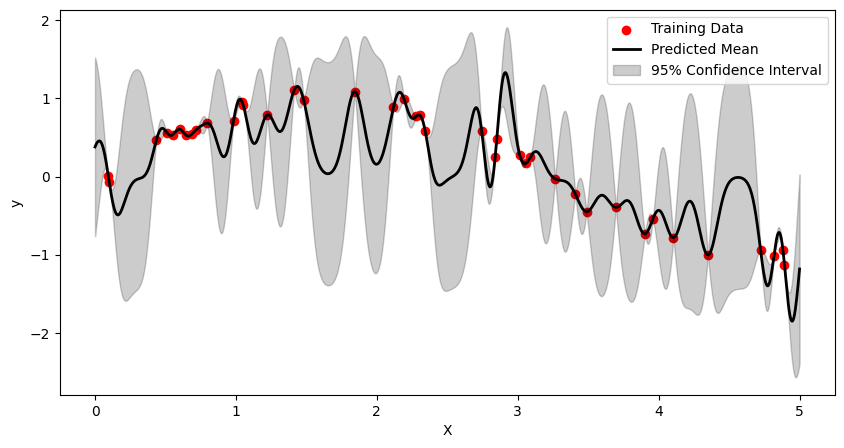

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

# Generate sample data
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel()

# Add noise to the data
y += 0.1 * np.random.randn(80)

# Define the kernel (RBF kernel)
kernel = 1.0 * RBF(length_scale=1.0)

# Create a Gaussian Process Regressor with the defined kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)
print("X Test: ", X_test.shape, "\nY Test: ", y_test.shape, "\nX Train: ", X_train.shape, "\nY Train: ", y_train.shape)

# Fit the Gaussian Process model to the training data
gp.fit(X_train, y_train)

# Make predictions on the test data
y_pred, sigma = gp.predict(X_test, return_std=True)
print("Predictions: ", y_pred.shape, "\nSigma: ", sigma.shape)

# Visualize the results
x = np.linspace(0, 5, 1000)[:, np.newaxis]
print("X: ", x.shape)
y_mean, y_cov = gp.predict(x, return_cov=True)
print("Mean: ", y_mean.shape, "\nCovariance: ", y_cov.shape)

plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, c='r', label='Training Data')
plt.plot(x, y_mean, 'k', lw=2, zorder=9, label='Predicted Mean')
plt.fill_between(x[:, 0], y_mean - 1.96 * np.sqrt(np.diag(y_cov)), y_mean + 1.96 *
                 np.sqrt(np.diag(y_cov)), alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Gaussian Random Field GPR

Now we want to apply the same principle on our Gaussian Random Field.

In [188]:
import numpy as np
import matplotlib.pyplot as plt
#import ipywidgets as widgets  # only needed for isosurfaces, comment out if you don't have it installed
#import ipyvolume as ipv # only needed for isosurfaces, comment out if you don't have it installed
%matplotlib inline
np.seterr(all='ignore')
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic as RQ, DotProduct as DP, Matern
from sklearn.gaussian_process.kernels import Kernel, GenericKernelMixin, StationaryKernelMixin, NormalizedKernelMixin
from scipy.special import gamma
from scipy.spatial.distance import cdist, pdist, squareform

We will generate a Gaussian Random Field with DFT as proposed in the lecture notes and use randomly chosen observations from it for our GPR later.

In [189]:
N = 16                          # we discretize our volume using N**3 cells
L = 1.0                           # the box size, sets the fundamental mode
dim = 3                           # dimension of the space

# create a Gaussian random field of size N**3
delta0 = np.random.normal(size=[N,N,N])

kmin = 2.0*np.pi/L # the fundamental mode of the box
kmax = kmin * N/2     # the Nyquist mode of each linear dimension
k1d = np.fft.fftfreq(N,d=1.0/kmin/N)  # get a 1D vector with all values of 'k'
kv = np.meshgrid(k1d,k1d,k1d) # turn this into 3 3D fields giving kx,ky,kz for each point
kmod = np.sqrt(kv[0]**2+kv[1]**2+kv[2]**2)               # get norm k for each point

# now 'kv' is the k vector, and 'kmod' its modulus at every point

alpha = 4
norm  = 1.0/(2.0*np.pi)**(-1.5)
# the matter power spectrum is the product of primordial spectrum and T**2
def P(k):
    return k**(-alpha)*norm

In [190]:
# generate a complex random field
fk = np.random.normal(size=(N,N,N)) + 1j * np.random.normal(size=(N,N,N))
fk = fk * np.sqrt(P(kmod))   # impose power spectrum 
fk[0,0,0] = 0.0     # zero f(k=0) to enforce zero mean

# compute (Fast) Fourier Transform of fk
f = np.real(np.fft.ifftn(fk))

# re-normalise (should be done using filtered variance)
f = f / np.std(f.flatten())

(16, 16, 16)

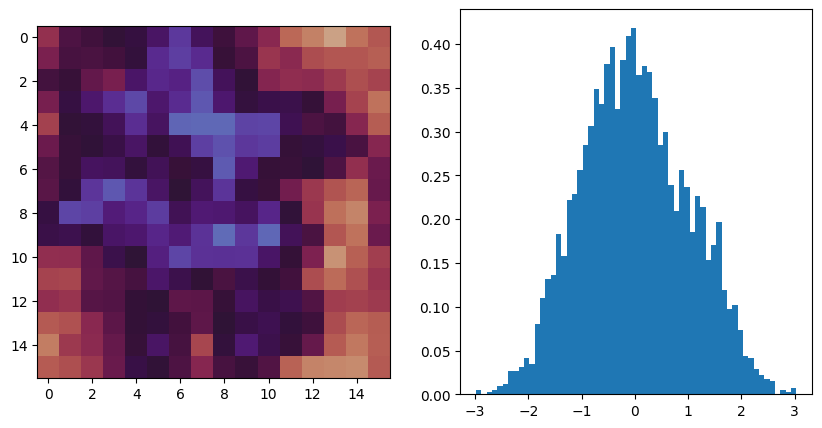

In [275]:
# Define the fixed range for the colorbar
vmin = -3
vmax = 3

fig, ax = plt.subplots(1, 2, figsize=[10, 5])

# Plot the image with a fixed color range
ax[0].imshow(f[..., N // 2], cmap='twilight', vmin=vmin, vmax=vmax)

# Add a colorbar to the imshow plot
#fig.colorbar(im, ax=ax[0], orientation='vertical')

# Plot the histogram
ax[1].hist(f.flatten(), bins=60, density=True)

plt.show()

In [211]:
class PowerSpectrumKernel3D(GenericKernelMixin, Kernel):
    def __init__(self, alpha=2, constant_value=1.0, nugget=1e-5):
        self.alpha = alpha
        self.constant_value = constant_value
        self.nugget = nugget

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        
        # Calculate pairwise Euclidean distances in 3D
        dists = np.sqrt(((X[:,np.newaxis]-Y[np.newaxis,:])**2).sum(axis=2))
        
        # Avoid zero distances to prevent division by zero or log(0)
        dists[dists == 0] = 1e-10
        
        # Compute the covariance matrix
        K = self.constant_value * np.abs(dists) ** (self.alpha - 3)
        
        if eval_gradient:
            # Gradient with respect to the hyperparameters, if needed
            K_gradient = np.zeros((X.shape[0], Y.shape[0], 2))

            # gradient with respect to constant_value
            K_gradient[..., 0] = K / self.constant_value

            # gradient with respect to alpha
            K_gradient[..., 1] = K * np.log(np.abs(dists))  
            return K, K_gradient
        
        return K

    def diag(self, X):
        return np.full(X.shape[0], self.constant_value + self.nugget)

    def is_stationary(self):
        return True

In [199]:
class PowerLawKernel(Kernel):
    def __init__(self, alpha=1.0, length_scale=1.0):
        self.alpha = alpha
        self.length_scale = length_scale

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return True

    def __repr__(self):
        return f"{self.__class__.__name__}(alpha={self.alpha}, length_scale={self.length_scale})"

    def evaluate_gradient(self, X, Y=None):
        if Y is None:
            dists = np.linalg.norm(X[:, np.newaxis] - X[np.newaxis, :], axis=2)
            K = self.__call__(X)
        else:
            dists = np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=2)
            K = self.__call__(X, Y)
        
        # Gradient with respect to length_scale
        K_gradient_length_scale = -((3 - self.alpha) * dists**2 * K) / (self.length_scale**2 + dists**2)
        
        # Gradient with respect to alpha
        K_gradient_alpha = -0.5 * np.log(self.length_scale**2 + dists**2) * K
        
        return np.stack([K_gradient_alpha, K_gradient_length_scale], axis=2)
    
    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            dists = np.linalg.norm(X[:, np.newaxis] - X[np.newaxis, :], axis=2)
        else:
            dists = np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=2)
        
        K = (self.length_scale**2 + dists**2)**(-(3 - self.alpha) / 2)

        if eval_gradient:
            K_gradient = self.evaluate_gradient(X, Y)
            return K, K_gradient


    @property
    def hyperparameters(self):
        return [Hyperparameter("alpha", "numeric", "fixed"),
                Hyperparameter("length_scale", "numeric", "fixed")]

    @property
    def theta(self):
        return np.log([self.alpha, self.length_scale])

    @theta.setter
    def theta(self, theta):
        self.alpha, self.length_scale = np.exp(theta)

    @property
    def bounds(self):
        return np.array([[1e-5, 1e5], [1e-5, 1e5]])

In [259]:
class RationalQuadratic(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    """Rational Quadratic kernel.

    The RationalQuadratic kernel can be seen as a scale mixture (an infinite
    sum) of RBF kernels with different characteristic length scales. It is
    parameterized by a length scale parameter :math:`l>0` and a scale
    mixture parameter :math:`\\alpha>0`. Only the isotropic variant
    where length_scale :math:`l` is a scalar is supported at the moment.
    The kernel is given by:

    .. math::
        k(x_i, x_j) = \\left(
        1 + \\frac{d(x_i, x_j)^2 }{ 2\\alpha  l^2}\\right)^{-\\alpha}

    where :math:`\\alpha` is the scale mixture parameter, :math:`l` is
    the length scale of the kernel and :math:`d(\\cdot,\\cdot)` is the
    Euclidean distance.
    For advice on how to set the parameters, see e.g. [1]_.

    Read more in the :ref:`User Guide <gp_kernels>`.

    .. versionadded:: 0.18

    Parameters
    ----------
    length_scale : float > 0, default=1.0
        The length scale of the kernel.

    alpha : float > 0, default=1.0
        Scale mixture parameter

    length_scale_bounds : pair of floats >= 0 or "fixed", default=(1e-5, 1e5)
        The lower and upper bound on 'length_scale'.
        If set to "fixed", 'length_scale' cannot be changed during
        hyperparameter tuning.

    alpha_bounds : pair of floats >= 0 or "fixed", default=(1e-5, 1e5)
        The lower and upper bound on 'alpha'.
        If set to "fixed", 'alpha' cannot be changed during
        hyperparameter tuning.

    References
    ----------
    .. [1] `David Duvenaud (2014). "The Kernel Cookbook:
        Advice on Covariance functions".
        <https://www.cs.toronto.edu/~duvenaud/cookbook/>`_

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.gaussian_process import GaussianProcessClassifier
    >>> from sklearn.gaussian_process.kernels import RationalQuadratic
    >>> X, y = load_iris(return_X_y=True)
    >>> kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)
    >>> gpc = GaussianProcessClassifier(kernel=kernel,
    ...         random_state=0).fit(X, y)
    >>> gpc.score(X, y)
    0.9733...
    >>> gpc.predict_proba(X[:2,:])
    array([[0.8881..., 0.0566..., 0.05518...],
            [0.8678..., 0.0707... , 0.0614...]])
    """

    def __init__(
        self,
        length_scale=1.0,
        alpha=1.0,
        length_scale_bounds=(1e-5, 1e5),
        alpha_bounds=(1e-5, 1e5),
    ):
        self.length_scale = length_scale
        self.alpha = alpha
        self.length_scale_bounds = length_scale_bounds
        self.alpha_bounds = alpha_bounds

    @property
    def hyperparameter_length_scale(self):
        return Hyperparameter("length_scale", "numeric", self.length_scale_bounds)

    @property
    def hyperparameter_alpha(self):
        return Hyperparameter("alpha", "numeric", self.alpha_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        """Return the kernel k(X, Y) and optionally its gradient.

        Parameters
        ----------
        X : ndarray of shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)

        Y : ndarray of shape (n_samples_Y, n_features), default=None
            Right argument of the returned kernel k(X, Y). If None, k(X, X)
            if evaluated instead.

        eval_gradient : bool, default=False
            Determines whether the gradient with respect to the log of
            the kernel hyperparameter is computed.
            Only supported when Y is None.

        Returns
        -------
        K : ndarray of shape (n_samples_X, n_samples_Y)
            Kernel k(X, Y)

        K_gradient : ndarray of shape (n_samples_X, n_samples_X, n_dims)
            The gradient of the kernel k(X, X) with respect to the log of the
            hyperparameter of the kernel. Only returned when eval_gradient
            is True.
        """
        if len(np.atleast_1d(self.length_scale)) > 1:
            raise AttributeError(
                "RationalQuadratic kernel only supports isotropic version, "
                "please use a single scalar for length_scale"
            )
        X = np.atleast_2d(X)
        if Y is None:
            dists = squareform(pdist(X, metric="sqeuclidean"))
            tmp = dists / (2 * self.alpha * self.length_scale**2)
            base = tmp
            K = base**-self.alpha
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError("Gradient can only be evaluated when Y is None.")
            dists = cdist(X, Y, metric="sqeuclidean")
            K = (dists / (2 * self.alpha * self.length_scale**2)) ** -self.alpha

        if eval_gradient:
            # gradient with respect to length_scale
            if not self.hyperparameter_length_scale.fixed:
                length_scale_gradient = dists * K / (self.length_scale**2 * base)
                length_scale_gradient = length_scale_gradient[:, :, np.newaxis]
            else:  # l is kept fixed
                length_scale_gradient = np.empty((K.shape[0], K.shape[1], 0))

            # gradient with respect to alpha
            if not self.hyperparameter_alpha.fixed:
                alpha_gradient = K * (
                    -self.alpha * np.log(base)
                    + dists / (2 * self.length_scale**2 * base)
                )
                alpha_gradient = alpha_gradient[:, :, np.newaxis]
            else:  # alpha is kept fixed
                alpha_gradient = np.empty((K.shape[0], K.shape[1], 0))

            return K, np.dstack((alpha_gradient, length_scale_gradient))
        else:
            return K

    def __repr__(self):
        return "{0}(alpha={1:.3g}, length_scale={2:.3g})".format(
            self.__class__.__name__, self.alpha, self.length_scale
        )


In [221]:
# Observations (example random points in a 3D space)
n_obs = 100
X_train = np.random.randint(0, N, size=(n_obs, 3))
y_train = [f[x[0],x[1],x[2]] for x in X_train]


# Points where we want to sample (a grid in a 3D space): array of shape (n_obs, n_features=3)
X = np.mgrid[0:N, 0:N, 0:N ]
X_test = np.column_stack([X[i].ravel() for i in range(3)])
#X_test = np.random.randint(0, N, size=(n_obs, 3))
#X_test.shape

In [222]:
# Hyperparameters
length_scale = L       # Given length scale
sigma_f = np.sqrt(norm)  # Scaling factor from the power spectrum normalization
alpha=2.5            # Power law index

# Define the kernel
constant_value = np.sqrt(np.pi**(alpha-dim/2) * gamma((dim-alpha)/2) / gamma(alpha/2))/2*alpha 
#kernel = PowerSpectrumKernel3D(alpha=alpha, constant_value=constant_value)
#kernel = RBF(length_scale=L, length_scale_bounds=(1e-5, 1e5))
nu = (dim - alpha) / 2
kernel = Matern(length_scale=constant_value, nu=nu)
#kernel = PowerLawKernel(alpha=alpha, length_scale=length_scale)

# Create the GaussianProcessRegressor object
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, n_restarts_optimizer=10) # alpha is the noise level

# Fit to the observed data
gp.fit(X_train, y_train)

# Make predictions
mu_s, cov_s = gp.predict(X_test, return_cov=True)

In [223]:
# Sample from the posterior distribution
#samples = np.random.multivariate_normal(mu_s, cov_s, (N, N, N)).reshape(N, N, N, n_obs)
samples = mu_s.reshape(N, N, N) 

y_test = [samples[x[0],x[1],x[2]] for x in X_train]

print(y_train[:5])
print(y_test[:5])

[0.2793325953366522, -1.445800714997842, -1.2023336478441449, -1.0189103368420966, 0.9096843215654699]
[0.2793325883214628, -1.445800708865281, -1.2023336400902256, -1.0189103334766032, 0.9096843051847373]


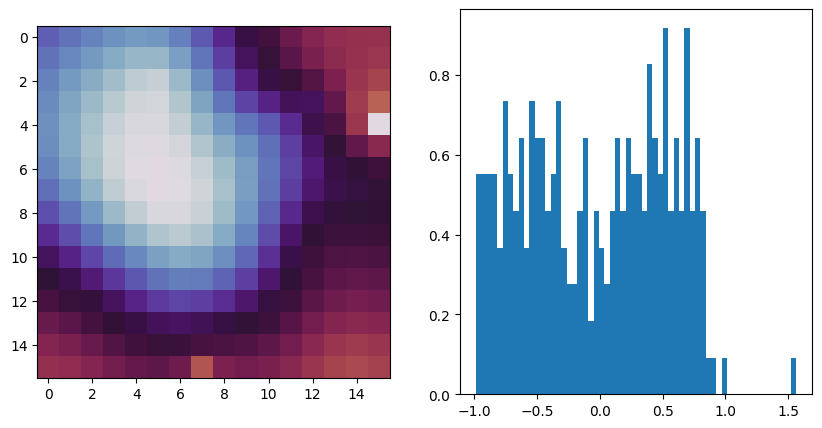

In [224]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(samples[..., N//2], cmap='twilight')
ax[1].hist(samples[..., N//2].flatten(), bins=60, density=True);

Alpha: 3.5, Constant Value: 50.448925389717665, Beta: 0.25


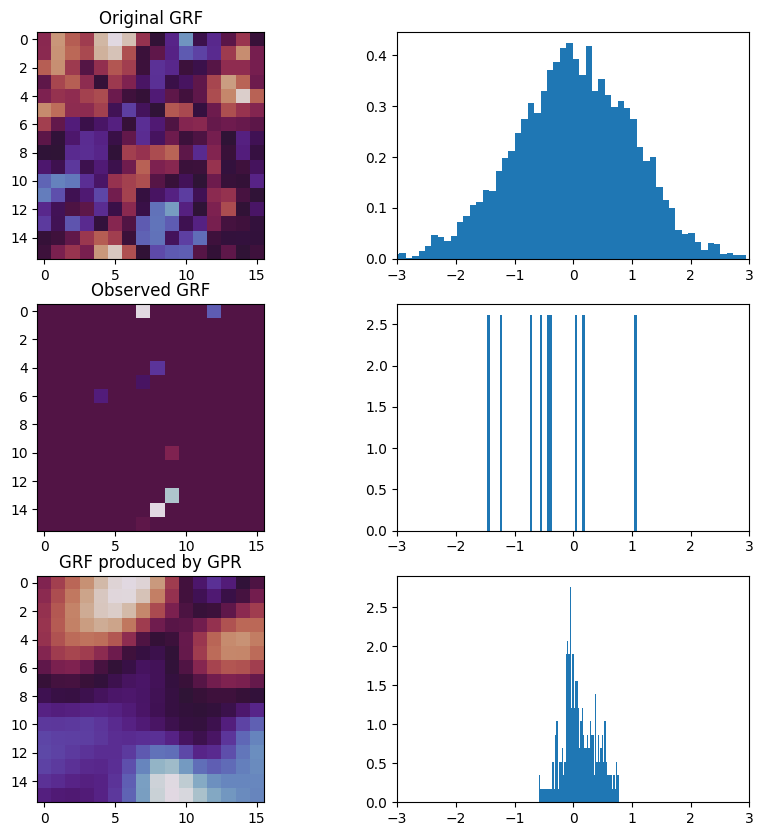

Alpha: 4.5, Constant Value: 453.2680504750925, Beta: 0.75


c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


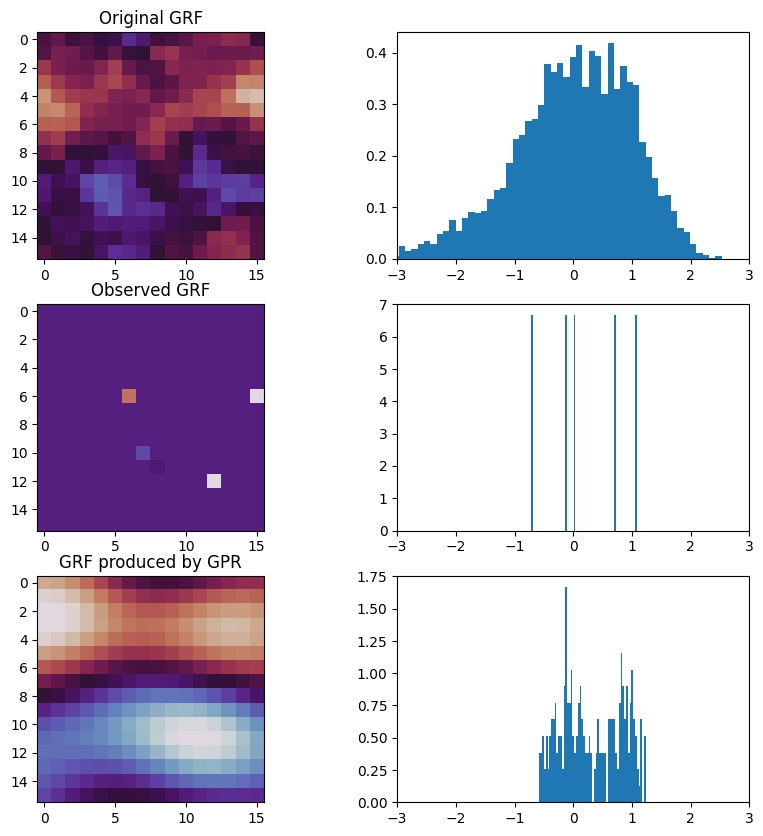

Alpha: 5.5, Constant Value: 4670.974409617155, Beta: 1.25


c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


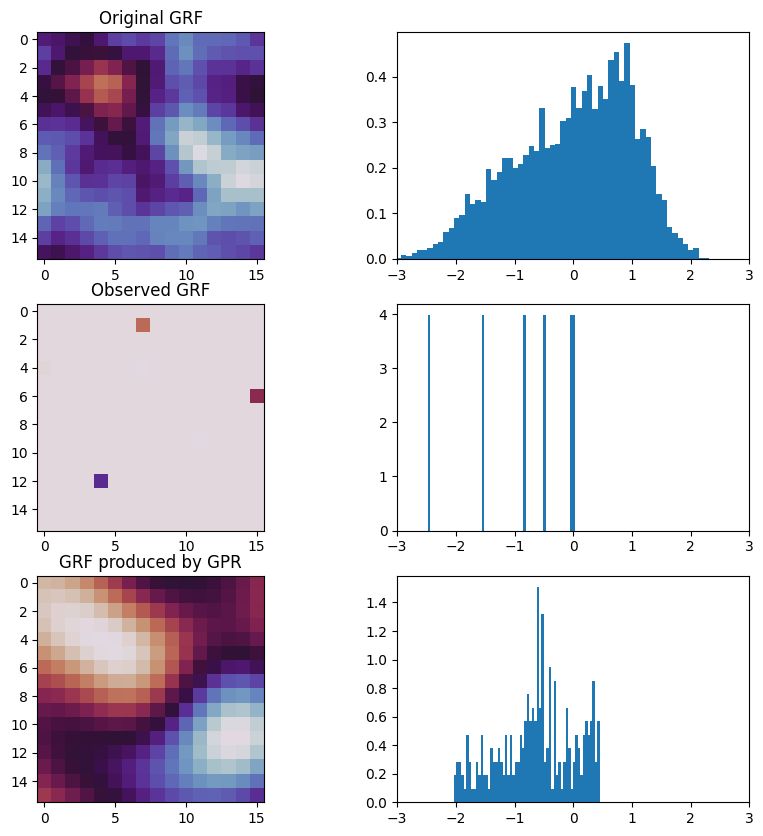

In [291]:
N = 16                          # we discretize our volume using N**3 cells
L = 1.0                           # the box size, sets the fundamental mode
dim = 3                           # dimension of the space

# create a Gaussian random field of size N**3
delta0 = np.random.normal(size=[N,N,N])

kmin = 2.0*np.pi/L # the fundamental mode of the box
kmax = kmin * N/2     # the Nyquist mode of each linear dimension
k1d = np.fft.fftfreq(N,d=1.0/kmin/N)  # get a 1D vector with all values of 'k'
kv = np.meshgrid(k1d,k1d,k1d) # turn this into 3 3D fields giving kx,ky,kz for each point
kmod = np.sqrt(kv[0]**2+kv[1]**2+kv[2]**2)               # get norm k for each point

# now 'kv' is the k vector, and 'kmod' its modulus at every point

for alpha in [3.5, 4.5, 5.5]:
     
    # Generate GRF with DFT

    norm  = 1.0/(2.0*np.pi)**(-1.5)
    # the matter power spectrum is the product of primordial spectrum and T**2
    def P(k):
        return k**(-alpha)*norm
    
    # generate a complex random field
    fk = np.random.normal(size=(N,N,N)) + 1j * np.random.normal(size=(N,N,N))
    fk = fk * np.sqrt(P(kmod))   # impose power spectrum 
    fk[0,0,0] = 0.0     # zero f(k=0) to enforce zero mean

    # compute (Fast) Fourier Transform of fk
    f = np.real(np.fft.ifftn(fk))

    # re-normalise (should be done using filtered variance)
    f = f / np.std(f.flatten())

    # Observations (example random points in a 3D space)
    n_obs = 100
    X_train = np.random.randint(0, N, size=(n_obs, 3))
    y_train = [f[x[0],x[1],x[2]] for x in X_train]


    # Points where we want to sample (a grid in a 3D space): array of shape (n_obs, n_features=3)
    X = np.mgrid[0:N, 0:N, 0:N ]
    X_test = np.column_stack([X[i].ravel() for i in range(3)])

    constant_value = abs(1/(alpha - dim) * np.pi**(alpha-dim/2) * gamma((dim-alpha)/2) / gamma(alpha/2)) ** ((alpha-dim)/2)
    beta = (alpha - dim) / 2

    print(f"Alpha: {alpha}, Constant Value: {constant_value}, Beta: {beta}")

    kernel = RQ(length_scale=constant_value, alpha=beta)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.5, n_restarts_optimizer=10)
    gp.fit(X_train, y_train)
    mu_s, cov_s = gp.predict(X_test, return_cov=True)
    samples = mu_s.reshape(N, N, N)

    # Define the fixed range for the colorbar
    vmin = -3
    vmax = 3

    fig, ax = plt.subplots(3, 2, figsize=[10, 10])

    # Plot original GRF
    ax[0,0].imshow(f[..., N // 2], cmap='twilight', vmin=vmin, vmax=vmax)
    ax[0, 0].set_title("Original GRF")
    ax[0,1].hist(f.flatten(), bins=60, density=True)
    ax[0, 1].set_xlim(vmin, vmax)


    # Plot the samples
    obs = np.zeros((N, N, N))
    for x in X_train:
        obs[x[0], x[1], x[2]] = f[x[0], x[1], x[2]]

    ax[1,0].imshow(obs[..., N//2], cmap='twilight')
    ax[1, 0].set_title("Observed GRF")
    obs_hist = obs[..., N//2].flatten()
    obs_hist = obs_hist[obs_hist != 0]
    ax[1,1].hist(obs_hist, bins=60, density=True)
    ax[1, 1].set_xlim(vmin, vmax)

    # Plot GRF produced by the GPR
    ax[2,0].imshow(samples[..., N//2], cmap='twilight')
    ax[2, 0].set_title("GRF produced by GPR")
    ax[2,1].hist(samples[..., N//2].flatten(), bins=60, density=True)
    ax[2, 1].set_xlim(vmin, vmax)

    plt.show()

In [310]:
def GRF_GPR(n_cells=16, box_size=1.0, dim=3, alpha=4, n_obs=100):    
    N = n_cells                          # we discretize our volume using N**3 cells
    L = box_size                          # the box size, sets the fundamental mode

    # create a Gaussian random field of size N**3
    delta0 = np.random.normal(size=[N,N,N])

    kmin = 2.0*np.pi/L # the fundamental mode of the box
    kmax = kmin * N/2     # the Nyquist mode of each linear dimension
    k1d = np.fft.fftfreq(N,d=1.0/kmin/N)  # get a 1D vector with all values of 'k'
    kv = np.meshgrid(k1d,k1d,k1d) # turn this into 3 3D fields giving kx,ky,kz for each point
    kmod = np.sqrt(kv[0]**2+kv[1]**2+kv[2]**2)               # get norm k for each point

    # now 'kv' is the k vector, and 'kmod' its modulus at every point
     
    # Generate GRF with DFT

    norm  = 1.0/(2.0*np.pi)**(-1.5)
    # the matter power spectrum is the product of primordial spectrum and T**2
    def P(k):
        return k**(-alpha)*norm
    
    # generate a complex random field
    fk = np.random.normal(size=(N,N,N)) + 1j * np.random.normal(size=(N,N,N))
    fk = fk * np.sqrt(P(kmod))   # impose power spectrum 
    fk[0,0,0] = 0.0     # zero f(k=0) to enforce zero mean

    # compute (Fast) Fourier Transform of fk
    f = np.real(np.fft.ifftn(fk))

    # re-normalise (should be done using filtered variance)
    f = f / np.std(f.flatten())

    # Observations (example random points in a 3D space)
    X_train = np.random.randint(0, N, size=(n_obs, 3))
    y_train = [f[x[0],x[1],x[2]] for x in X_train]


    # Points where we want to sample (a grid in a 3D space): array of shape (n_obs, n_features=3)
    X = np.mgrid[0:N, 0:N, 0:N ]
    X_test = np.column_stack([X[i].ravel() for i in range(3)])

    constant_value = abs(1/(alpha - dim) * np.pi**(alpha-dim/2) * gamma((dim-alpha)/2) / gamma(alpha/2)) ** ((alpha-dim)/2)
    beta = (alpha - dim) / 2

    print(f"Alpha: {alpha}, Constant Value: {constant_value}, Beta: {beta}")

    kernel = RQ(length_scale=constant_value, alpha=beta)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.5, n_restarts_optimizer=10)
    gp.fit(X_train, y_train)
    mu_s, cov_s = gp.predict(X_test, return_cov=True)
    samples = mu_s.reshape(N, N, N)

    # Define the fixed range for the colorbar
    vmin = -3
    vmax = 3

    fig, ax = plt.subplots(3, 2, figsize=[10, 10])

    # Plot original GRF
    ax[0,0].imshow(f[..., N // 2], cmap='twilight', vmin=vmin, vmax=vmax)
    ax[0, 0].set_title("Original GRF")
    ax[0,1].hist(f.flatten(), bins=60, density=True)
    ax[0, 1].set_xlim(vmin, vmax)


    # Plot the samples
    obs = np.zeros((N, N, N))
    for x in X_train:
        obs[x[0], x[1], x[2]] = f[x[0], x[1], x[2]]

    ax[1,0].imshow(obs[..., N//2], cmap='twilight')
    ax[1, 0].set_title("Observed GRF")
    obs_hist = obs[..., N//2].flatten()
    obs_hist = obs_hist[obs_hist != 0]
    ax[1,1].hist(obs_hist, bins=60, density=True)
    ax[1, 1].set_xlim(vmin, vmax)

    # Plot GRF produced by the GPR
    ax[2,0].imshow(samples[..., N//2], cmap='twilight')
    ax[2, 0].set_title("GRF produced by GPR")
    ax[2,1].hist(samples[..., N//2].flatten(), bins=60, density=True)
    ax[2, 1].set_xlim(vmin, vmax)

    plt.show()

Alpha: 3.5, Constant Value: 3.203185701968419, Beta: 0.25


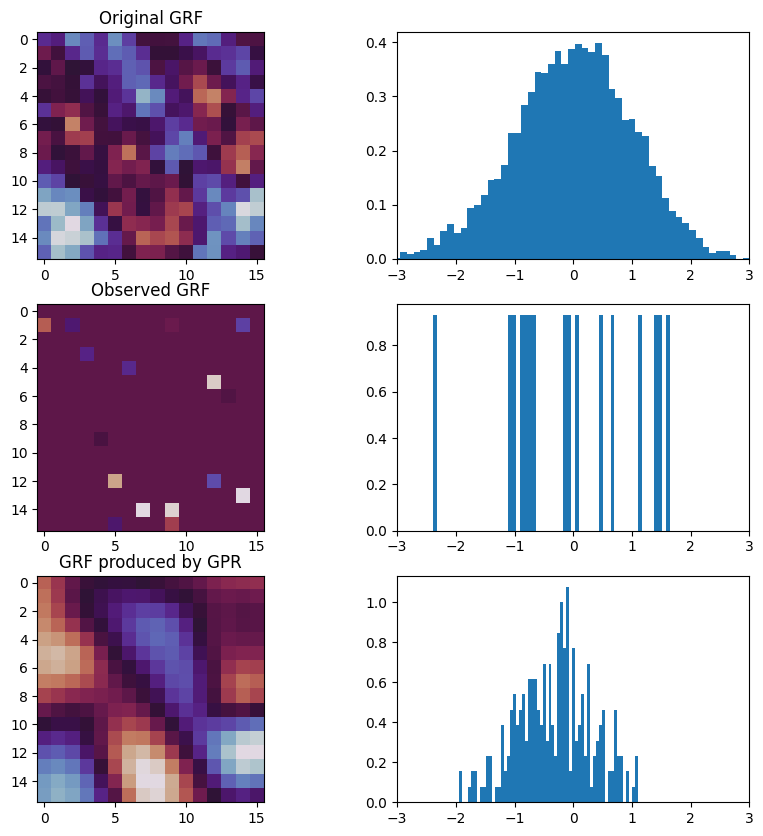

Alpha: 4.5, Constant Value: 28.77963657748868, Beta: 0.75


c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


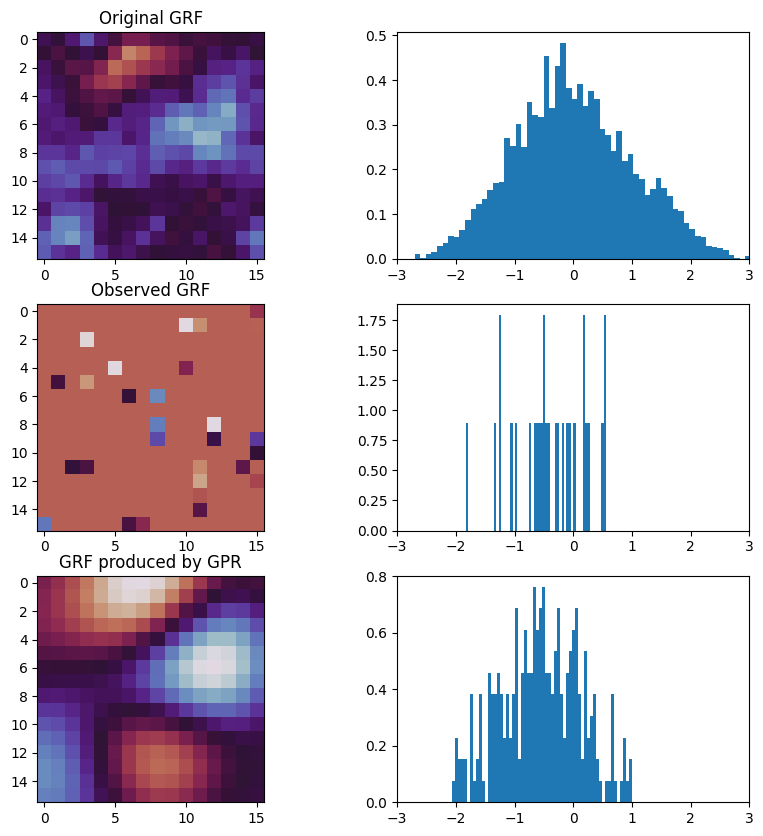

Alpha: 5.5, Constant Value: 296.57714862238777, Beta: 1.25


c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [311]:
for alpha in [3.5, 4.5, 5.5]:
    GRF_GPR(n_cells=16, box_size=1.0, dim=3, alpha=alpha, n_obs=300)

In [12]:
from scipy.spatial.distance import cdist, pdist, squareform
from collections import namedtuple

def _check_length_scale(X, length_scale):
    length_scale = np.squeeze(length_scale).astype(float)
    if np.ndim(length_scale) > 1:
        raise ValueError("length_scale cannot be of dimension greater than 1")
    if np.ndim(length_scale) == 1 and X.shape[1] != length_scale.shape[0]:
        raise ValueError(
            "Anisotropic kernel must have the same number of "
            "dimensions as data (%d!=%d)" % (length_scale.shape[0], X.shape[1])
        )
    return length_scale

class Hyperparameter(
    namedtuple(
        "Hyperparameter", ("name", "value_type", "bounds", "n_elements", "fixed")
    )
):
    """A kernel hyperparameter's specification in form of a namedtuple.

    .. versionadded:: 0.18

    Attributes
    ----------
    name : str
        The name of the hyperparameter. Note that a kernel using a
        hyperparameter with name "x" must have the attributes self.x and
        self.x_bounds

    value_type : str
        The type of the hyperparameter. Currently, only "numeric"
        hyperparameters are supported.

    bounds : pair of floats >= 0 or "fixed"
        The lower and upper bound on the parameter. If n_elements>1, a pair
        of 1d array with n_elements each may be given alternatively. If
        the string "fixed" is passed as bounds, the hyperparameter's value
        cannot be changed.

    n_elements : int, default=1
        The number of elements of the hyperparameter value. Defaults to 1,
        which corresponds to a scalar hyperparameter. n_elements > 1
        corresponds to a hyperparameter which is vector-valued,
        such as, e.g., anisotropic length-scales.

    fixed : bool, default=None
        Whether the value of this hyperparameter is fixed, i.e., cannot be
        changed during hyperparameter tuning. If None is passed, the "fixed" is
        derived based on the given bounds.

    Examples
    --------
    >>> from sklearn.gaussian_process.kernels import ConstantKernel
    >>> from sklearn.datasets import make_friedman2
    >>> from sklearn.gaussian_process import GaussianProcessRegressor
    >>> from sklearn.gaussian_process.kernels import Hyperparameter
    >>> X, y = make_friedman2(n_samples=50, noise=0, random_state=0)
    >>> kernel = ConstantKernel(constant_value=1.0,
    ...    constant_value_bounds=(0.0, 10.0))

    We can access each hyperparameter:

    >>> for hyperparameter in kernel.hyperparameters:
    ...    print(hyperparameter)
    Hyperparameter(name='constant_value', value_type='numeric',
    bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)

    >>> params = kernel.get_params()
    >>> for key in sorted(params): print(f"{key} : {params[key]}")
    constant_value : 1.0
    constant_value_bounds : (0.0, 10.0)
    """

    # A raw namedtuple is very memory efficient as it packs the attributes
    # in a struct to get rid of the __dict__ of attributes in particular it
    # does not copy the string for the keys on each instance.
    # By deriving a namedtuple class just to introduce the __init__ method we
    # would also reintroduce the __dict__ on the instance. By telling the
    # Python interpreter that this subclass uses static __slots__ instead of
    # dynamic attributes. Furthermore we don't need any additional slot in the
    # subclass so we set __slots__ to the empty tuple.
    __slots__ = ()

    def __new__(cls, name, value_type, bounds, n_elements=1, fixed=None):
        if not isinstance(bounds, str) or bounds != "fixed":
            bounds = np.atleast_2d(bounds)
            if n_elements > 1:  # vector-valued parameter
                if bounds.shape[0] == 1:
                    bounds = np.repeat(bounds, n_elements, 0)
                elif bounds.shape[0] != n_elements:
                    raise ValueError(
                        "Bounds on %s should have either 1 or "
                        "%d dimensions. Given are %d"
                        % (name, n_elements, bounds.shape[0])
                    )

        if fixed is None:
            fixed = isinstance(bounds, str) and bounds == "fixed"
        return super(Hyperparameter, cls).__new__(
            cls, name, value_type, bounds, n_elements, fixed
        )

    # This is mainly a testing utility to check that two hyperparameters
    # are equal.
    def __eq__(self, other):
        return (
            self.name == other.name
            and self.value_type == other.value_type
            and np.all(self.bounds == other.bounds)
            and self.n_elements == other.n_elements
            and self.fixed == other.fixed
        )

class PowerSpectrumKernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    """Radial basis function kernel (aka squared-exponential kernel).

    The RBF kernel is a stationary kernel. It is also known as the
    "squared exponential" kernel. It is parameterized by a length scale
    parameter :math:`l>0`, which can either be a scalar (isotropic variant
    of the kernel) or a vector with the same number of dimensions as the inputs
    X (anisotropic variant of the kernel). The kernel is given by:

    .. math::
        k(x_i, x_j) = \\exp\\left(- \\frac{d(x_i, x_j)^2}{2l^2} \\right)

    where :math:`l` is the length scale of the kernel and
    :math:`d(\\cdot,\\cdot)` is the Euclidean distance.
    For advice on how to set the length scale parameter, see e.g. [1]_.

    This kernel is infinitely differentiable, which implies that GPs with this
    kernel as covariance function have mean square derivatives of all orders,
    and are thus very smooth.
    See [2]_, Chapter 4, Section 4.2, for further details of the RBF kernel.

    Read more in the :ref:`User Guide <gp_kernels>`.

    .. versionadded:: 0.18

    Parameters
    ----------
    length_scale : float or ndarray of shape (n_features,), default=1.0
        The length scale of the kernel. If a float, an isotropic kernel is
        used. If an array, an anisotropic kernel is used where each dimension
        of l defines the length-scale of the respective feature dimension.

    length_scale_bounds : pair of floats >= 0 or "fixed", default=(1e-5, 1e5)
        The lower and upper bound on 'length_scale'.
        If set to "fixed", 'length_scale' cannot be changed during
        hyperparameter tuning.

    References
    ----------
    .. [1] `David Duvenaud (2014). "The Kernel Cookbook:
        Advice on Covariance functions".
        <https://www.cs.toronto.edu/~duvenaud/cookbook/>`_

    .. [2] `Carl Edward Rasmussen, Christopher K. I. Williams (2006).
        "Gaussian Processes for Machine Learning". The MIT Press.
        <http://www.gaussianprocess.org/gpml/>`_

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.gaussian_process import GaussianProcessClassifier
    >>> from sklearn.gaussian_process.kernels import RBF
    >>> X, y = load_iris(return_X_y=True)
    >>> kernel = 1.0 * RBF(1.0)
    >>> gpc = GaussianProcessClassifier(kernel=kernel,
    ...         random_state=0).fit(X, y)
    >>> gpc.score(X, y)
    0.9866...
    >>> gpc.predict_proba(X[:2,:])
    array([[0.8354..., 0.03228..., 0.1322...],
           [0.7906..., 0.0652..., 0.1441...]])
    """

    def __init__(self, alpha=4, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds
        self.alpha = alpha

    @property
    def anisotropic(self):
        return np.iterable(self.length_scale) and len(self.length_scale) > 1

    @property
    def hyperparameter_length_scale(self):
        if self.anisotropic:
            return Hyperparameter(
                "length_scale",
                "numeric",
                self.length_scale_bounds,
                len(self.length_scale),
            )
        return Hyperparameter("length_scale", "numeric", self.length_scale_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        """Return the kernel k(X, Y) and optionally its gradient.

        Parameters
        ----------
        X : ndarray of shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)

        Y : ndarray of shape (n_samples_Y, n_features), default=None
            Right argument of the returned kernel k(X, Y). If None, k(X, X)
            if evaluated instead.

        eval_gradient : bool, default=False
            Determines whether the gradient with respect to the log of
            the kernel hyperparameter is computed.
            Only supported when Y is None.

        Returns
        -------
        K : ndarray of shape (n_samples_X, n_samples_Y)
            Kernel k(X, Y)

        K_gradient : ndarray of shape (n_samples_X, n_samples_X, n_dims), \
                optional
            The gradient of the kernel k(X, X) with respect to the log of the
            hyperparameter of the kernel. Only returned when `eval_gradient`
            is True.
        """
        X = np.atleast_2d(X)
        length_scale = _check_length_scale(X, self.length_scale)
        if Y is None:
            dists = pdist(X / length_scale, metric="sqeuclidean")
            K = abs(dists) ** (self.alpha - 3)
            # convert from upper-triangular matrix to square matrix
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError("Gradient can only be evaluated when Y is None.")
            dists = cdist(X / length_scale, Y / length_scale, metric="sqeuclidean")
            K = abs(dists) ** (self.alpha - 3)

        if eval_gradient:
            """if self.hyperparameter_length_scale.fixed:
                # Hyperparameter l kept fixed
                #return K, np.empty((X.shape[0], X.shape[0], 0))
            elif not self.anisotropic or length_scale.shape[0] == 1:
                K_gradient = (K * squareform(dists))[:, :, np.newaxis]
                #return K, K_gradient
            elif self.anisotropic:
                # We need to recompute the pairwise dimension-wise distances
                K_gradient = (X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2 / (
                    length_scale**2
                )
                K_gradient *= K[..., np.newaxis]
                #return K, K_gradient"""
            
            # Gradient with respect to the hyperparameters
            K_gradient = np.zeros((X.shape[0], Y.shape[0], 2))
            K_gradient[..., 0] = K / self.constant_value  # gradient with respect to constant_value
            K_gradient[..., 1] = K * np.log(np.abs(dists))  # gradient with respect to alpha
            return K, K_gradient


        else:
            return K

    def __repr__(self):
        if self.anisotropic:
            return "{0}(length_scale=[{1}])".format(
                self.__class__.__name__,
                ", ".join(map("{0:.3g}".format, self.length_scale)),
            )
        else:  # isotropic
            return "{0}(length_scale={1:.3g})".format(
                self.__class__.__name__, np.ravel(self.length_scale)[0]
            )